<h2 align="center"><b>Лабораторна робота №4</b></h2>
<h3 align="center">Аналіз та математичне моделювання COVID-19 за моделлю SIR</h3>
<h5 align="right">Роботу виконав студент групи ФІ-21, Беркута Володимир</h5>

### **Мета роботи**
Навчитися працювати з наборами даних з платформи Kaggle на прикладі набору даних про Covid-19. Ознайомитись та навчитись використовувати модель SIR(математична модель для розуміння спалаху інфекційних захворювань). Навчитись аналізувати тренди змін захворюваності.

### **Дані та приклади**
За наведеним посиланням знаходиться приклади, де аналізується взаємозв'язок заходів проти COVID-19 та кількості інфікованих. Мета - проаналізувати хід захворюваності та спрогнозувати можливий стан захворюванності в країні, що може допомогти швидше врегулювати ситуацію.

В прикладі використана модель SIR-F, похідною від моделі SIR. Оцінка параметрів SIR-F застосована до підмножини даних часових рядів у кожній країні. Точки зміни параметрів визначаються аналізом тенденцій S-R. Пожробиці пояснені в розділі "Метод".

### **Завдання**
Лабораторну роботу можна виконувати в Kaggle, Colaboratory, IPython Notebook (або в буль якому іншому програмному забезпеченні).
1) Проаналізувати в яких країнах наразі відбувається спалах захворювань, а в яких відбувається затухання захворювань.
2) Згідно уподобань з переліку обрати одну країну, в якій відбувається спалах, та одну країну, для якої відбувається затухання, та застосувати до неї модель SIR-F.(в даному випадку задача вибору країни є творчою, можна також орієнтуватися на їх географічне розташування, кількість населення тощо).
3) Для обраних країн визначити параметри моделі ($\theta$, $\kappa$, $\rho$, $\sigma$, $\tau$, ...), вивести їх на графіку з плином часу.
4) Спрогнозувати показники Infected, Fatal, Recovered з використанням отриманих параметрів на 7, 30 та 300 днів.
5) Визначити найближчий пік захворюваності(дата).
6) Визначити коли в країні не залишиться хворих на Covid-19.
7) Порівняти отримані результати для обраних країн.
8) Отримані результати оформити у вигляді звіту до лабораторної роботи.

Обрані країни: Vietnam, Togo

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

In [37]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/full_data.csv'
data = pd.read_csv(url)

In [26]:
data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
0,2020-02-24,Afghanistan,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
1,2020-02-25,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
2,2020-02-26,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,2020-02-27,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
4,2020-02-28,Afghanistan,0.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN


In [29]:
data = data.dropna()
data.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
40,2020-04-04,Afghanistan,1.0,0.0,270.0,5.0,164.0,3.0,246.0,5.0
41,2020-04-05,Afghanistan,29.0,2.0,299.0,7.0,185.0,3.0,265.0,7.0
42,2020-04-06,Afghanistan,38.0,0.0,337.0,7.0,223.0,3.0,297.0,6.0
43,2020-04-07,Afghanistan,30.0,4.0,367.0,11.0,201.0,7.0,325.0,10.0
44,2020-04-08,Afghanistan,56.0,3.0,423.0,14.0,231.0,10.0,349.0,13.0


<Axes: >

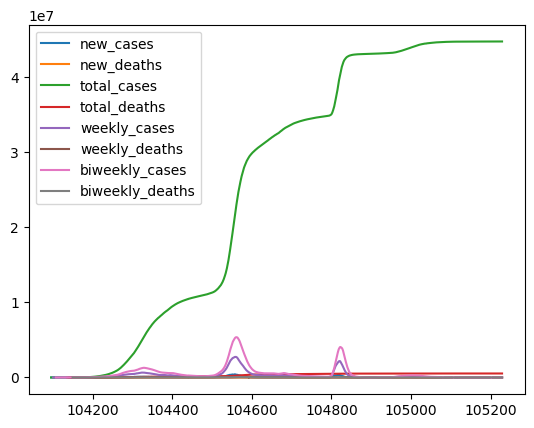

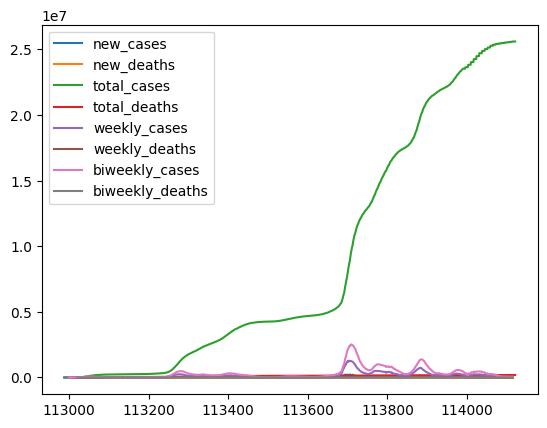

In [53]:
data[data["location"]=="India"].plot()
data[data["location"]=="Italy"].plot()

In [55]:
# Filter data for selected countries
country_spike = "India"
country_decline = "Italy"

# Prepare data for India
india_data = data[data["location"] == country_spike]
india_data = india_data[["date", "total_cases", "total_deaths"]].fillna(0)
india_data["date"] = pd.to_datetime(india_data["date"])
india_data.set_index("date", inplace=True)

# Prepare data for Italy
italy_data = data[data["location"] == country_decline]
italy_data = italy_data[["date", "total_cases", "total_deaths"]].fillna(0)
italy_data["date"] = pd.to_datetime(italy_data["date"])
italy_data.set_index("date", inplace=True)

display(india_data.head())
display(italy_data.head())

,total_cases,total_deaths
date,,
2020-01-30,1.0,0.0
2020-01-31,1.0,0.0
2020-02-01,1.0,0.0
2020-02-02,2.0,0.0
2020-02-03,3.0,0.0


,total_cases,total_deaths
date,,
2020-01-31,2.0,0.0
2020-02-01,2.0,0.0
2020-02-02,2.0,0.0
2020-02-03,2.0,0.0
2020-02-04,2.0,0.0


In [56]:
# Define SIR-F model equations
def sirf_model(y, t, theta, kappa, rho, sigma):
    S, I, R, F = y
    N = S + I + R + F
    dS_dt = -theta * kappa * S * I / N
    dI_dt = theta * kappa * S * I / N - rho * I - sigma * I
    dR_dt = rho * I
    dF_dt = sigma * I
    return [dS_dt, dI_dt, dR_dt, dF_dt]

In [57]:
# Fit data to SIR-F model
def fit_sirf_model(data, initial_conditions, t):
    def model(params):
        theta, kappa, rho, sigma = params
        solution = odeint(sirf_model, initial_conditions, t, args=(theta, kappa, rho, sigma))
        return solution[:, 1]  # Return only Infected data
    I_actual = data["total_cases"].values
    params_opt, _ = curve_fit(lambda t, theta, kappa, rho, sigma: model([theta, kappa, rho, sigma]), t, I_actual)
    return params_opt

In [ ]:
# Initialize model parameters for India
N_india = 1_380_000_000  # Population of India
I0_india = india_data.iloc[0]["total_cases"]
F0_india = india_data.iloc[0]["total_deaths"]
R0_india = 0  # Start with 0 recovered
S0_india = N_india - I0_india - R0_india - F0_india
initial_conditions_india = [S0_india, I0_india, R0_india, F0_india]
t_india = np.arange(len(india_data))

params_india = fit_sirf_model(india_data, initial_conditions_india, t_india)

# Initialize model parameters for Italy
N_italy = 60_360_000  # Population of Italy
I0_italy = italy_data.iloc[0]["total_cases"]
F0_italy = italy_data.iloc[0]["total_deaths"]
R0_italy = 0  # Start with 0 recovered
S0_italy = N_italy - I0_italy - R0_italy - F0_italy
initial_conditions_italy = [S0_italy, I0_italy, R0_italy, F0_italy]
t_italy = np.arange(len(italy_data))

params_italy = fit_sirf_model(italy_data, initial_conditions_italy, t_italy)

# Predict for the next 300 days
future_days = 300
t_future = np.arange(future_days)

sirf_india_future = odeint(sirf_model, initial_conditions_india, t_future, args=tuple(params_india))
sirf_italy_future = odeint(sirf_model, initial_conditions_italy, t_future, args=tuple(params_italy))

C:\Users\berku\AppData\Local\Temp\ipykernel_31312\612868276.py:35: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(sirf_model, initial_conditions, t, args=(theta, kappa, rho, sigma))
C:\Users\berku\AppData\Local\Temp\ipykernel_31312\612868276.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  dS_dt = -theta * kappa * S * I / N
C:\Users\berku\AppData\Local\Temp\ipykernel_31312\612868276.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  dI_dt = theta * kappa * S * I / N - rho * I - sigma * I
C:\Users\berku\AppData\Local\Temp\ipykernel_31312\612868276.py:25: RuntimeWarning: invalid value encountered in scalar divide
  dS_dt = -theta * kappa * S * I / N
C:\Users\berku\AppData\Local\Temp\ipykernel_31312\612868276.py:26: RuntimeWarning: invalid value encountered in scalar divide
  dI_dt = theta * kappa * S * I / N - rho * I - sigma * I
C:\Users\berku\AppD

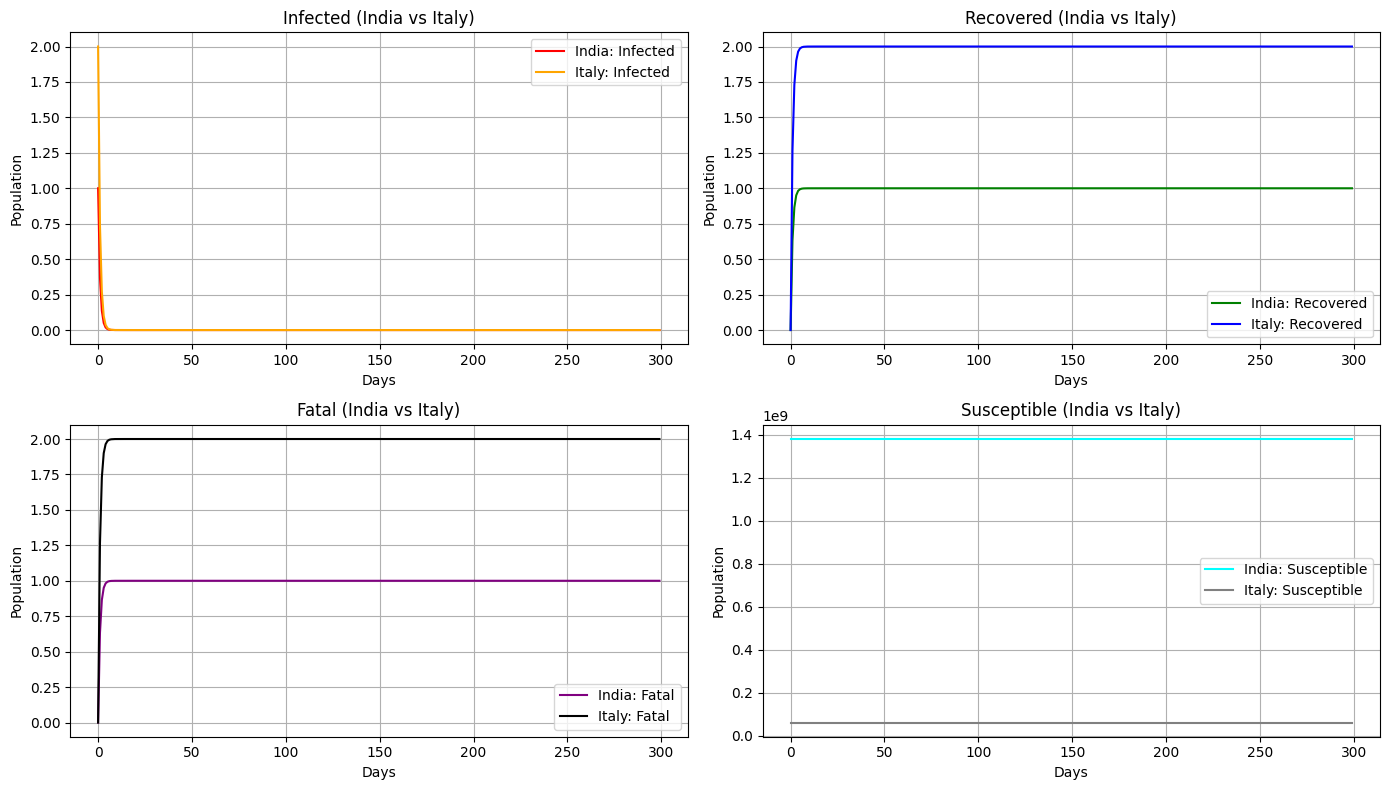

India - Theta: 1.0000, Kappa: 1.0000, Rho: 1.0000, Sigma: 1.0000
Italy - Theta: 1.0000, Kappa: 1.0000, Rho: 1.0000, Sigma: 1.0000


In [ ]:
# Plot comparisons of parameters
plt.figure(figsize=(14, 8))

# Infected comparison
plt.subplot(2, 2, 1)
plt.plot(t_future, sirf_india_future[:, 1], label="India: Infected", color="red")
plt.plot(t_future, sirf_italy_future[:, 1], label="Italy: Infected", color="orange")
plt.title("Infected (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Recovered comparison
plt.subplot(2, 2, 2)
plt.plot(t_future, sirf_india_future[:, 2], label="India: Recovered", color="green")
plt.plot(t_future, sirf_italy_future[:, 2], label="Italy: Recovered", color="blue")
plt.title("Recovered (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Fatal comparison
plt.subplot(2, 2, 3)
plt.plot(t_future, sirf_india_future[:, 3], label="India: Fatal", color="purple")
plt.plot(t_future, sirf_italy_future[:, 3], label="Italy: Fatal", color="black")
plt.title("Fatal (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

# Susceptible comparison
plt.subplot(2, 2, 4)
plt.plot(t_future, sirf_india_future[:, 0], label="India: Susceptible", color="cyan")
plt.plot(t_future, sirf_italy_future[:, 0], label="Italy: Susceptible", color="gray")
plt.title("Susceptible (India vs Italy)")
plt.xlabel("Days")
plt.ylabel("Population")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

print(f"India - Theta: {params_india[0]:.4f}, Kappa: {params_india[1]:.4f}, Rho: {params_india[2]:.4f}, Sigma: {params_india[3]:.4f}")
print(f"Italy - Theta: {params_italy[0]:.4f}, Kappa: {params_italy[1]:.4f}, Rho: {params_italy[2]:.4f}, Sigma: {params_italy[3]:.4f}")